Import des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import datetime as dt
import sklearn
import sklearn.metrics
import statsmodels.api as sm
import pingouin as pg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import pmdarima as pm

/home/kipengui/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/kipengui/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Extraction et import du fichier

In [2]:
zipfile.ZipFile('data_conso.zip').extractall('.')

with zipfile.ZipFile('data_conso.zip') as archive:
        archive.printdir()

File Name                                             Modified             Size
data_conso.csv                                 2022-09-06 12:45:00       385245


In [3]:
data_conso=pd.read_csv('data_conso.csv')
data_conso.head()

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies
0,2012-01-01,2471592.0,4901850.0,4841050.0,23649.0,758.0,181778.0,2153346.0,188459.0,6255.0,367472.0,-86821.0,33411.0
1,2012-01-02,2912815.0,5796450.0,5739050.0,23598.0,378.0,194404.0,2557111.0,147353.0,4267.0,412364.0,-50571.0,31219.0
2,2012-01-03,3252581.0,6349550.0,6392550.0,24700.0,205.0,193376.0,2794380.0,228569.0,6768.0,484559.0,-48850.0,31888.0
3,2012-01-04,3265403.0,6455450.0,6430900.0,26208.0,7.0,178234.0,2767347.0,203392.0,8655.0,490193.0,-42190.0,32737.0
4,2012-01-05,3319555.0,6410150.0,6484500.0,25809.0,16.0,203859.0,2712466.0,249564.0,3207.0,516675.0,-40085.0,32991.0


In [4]:
data_conso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          3288 non-null   object 
 1   consommation  3288 non-null   float64
 2   prevision_j1  3288 non-null   float64
 3   prevision_j   3288 non-null   float64
 4   fioul         3288 non-null   float64
 5   charbon       3288 non-null   float64
 6   gaz           3288 non-null   float64
 7   nucleaire     3288 non-null   float64
 8   eolien        3288 non-null   float64
 9   solaire       3288 non-null   float64
 10  hydraulique   3288 non-null   float64
 11  pompage       3288 non-null   float64
 12  bioenergies   3288 non-null   float64
dtypes: float64(12), object(1)
memory usage: 334.1+ KB


In [5]:
# Changement du type de la variable 'date'
# Création de la colonne 'mois' pour une étude mensualisée

data_conso['date']=pd.to_datetime(data_conso['date'], format='%Y-%m-%d', errors= 'coerce')
data_conso['mois']=data_conso['date'].apply(lambda x: x.strftime('%Y %m'))
data_conso['mois']=pd.to_datetime(data_conso['mois'], format='%Y %m')

In [6]:
len(data_conso)

3288

In [7]:
data_conso['date'].nsmallest(1)

0   2012-01-01
Name: date, dtype: datetime64[ns]

In [8]:
data_conso['date'].nlargest(1)

3287   2020-12-31
Name: date, dtype: datetime64[ns]

Représentation de la série temporelle journalière

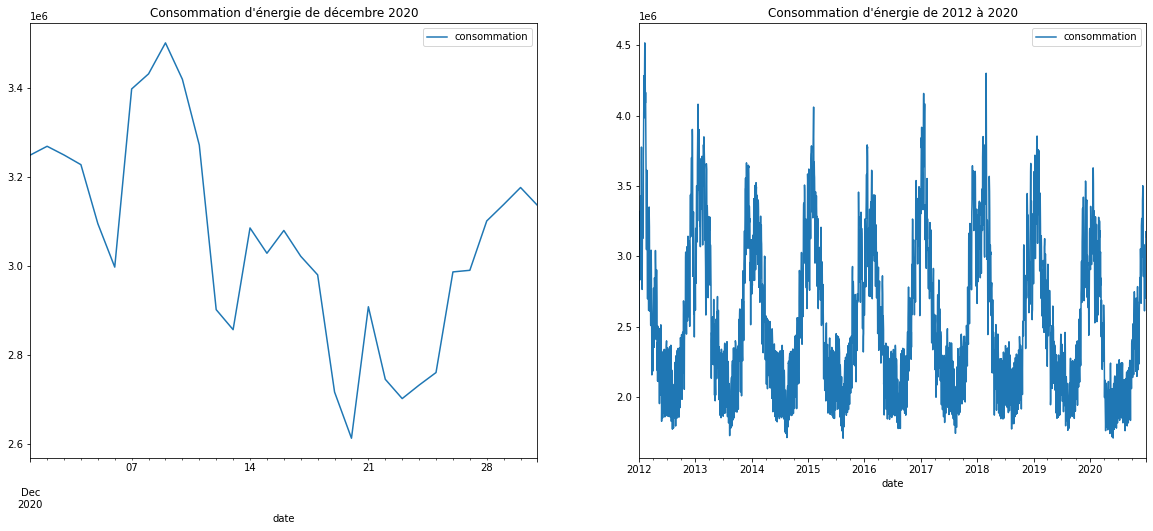

In [9]:
conso=data_conso[['date', 'consommation']]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
conso.iloc[-31:].set_index('date').plot(ax=ax[0])
conso.set_index('date').plot(ax=ax[1])
ax[0].set_title("Consommation d'énergie de décembre 2020")
ax[1].set_title("Consommation d'énergie de 2012 à 2020")
plt.savefig('P9_consommation_journalière.jpg')

Représentation de la série temporelle mensuelle

In [10]:
data_conso.set_index('mois', inplace=True)

In [11]:
data_conso

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies
mois,,,,,,,,,,,,,
2012-01-01,2012-01-01,2471592.0,4901850.0,4841050.0,23649.0,758.0,181778.0,2153346.0,188459.0,6255.0,367472.0,-86821.0,33411.0
2012-01-01,2012-01-02,2912815.0,5796450.0,5739050.0,23598.0,378.0,194404.0,2557111.0,147353.0,4267.0,412364.0,-50571.0,31219.0
2012-01-01,2012-01-03,3252581.0,6349550.0,6392550.0,24700.0,205.0,193376.0,2794380.0,228569.0,6768.0,484559.0,-48850.0,31888.0
2012-01-01,2012-01-04,3265403.0,6455450.0,6430900.0,26208.0,7.0,178234.0,2767347.0,203392.0,8655.0,490193.0,-42190.0,32737.0
2012-01-01,2012-01-05,3319555.0,6410150.0,6484500.0,25809.0,16.0,203859.0,2712466.0,249564.0,3207.0,516675.0,-40085.0,32991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,2020-12-27,2990748.0,5842450.0,5976350.0,4460.0,404.0,116636.0,2125269.0,519656.0,12306.0,298783.0,-82738.0,53499.0
2020-12-01,2020-12-28,3101704.0,6460350.0,6156450.0,4495.0,421.0,186115.0,2268938.0,368355.0,19619.0,433347.0,-39110.0,52210.0
2020-12-01,2020-12-29,3138620.0,6264900.0,6239650.0,4494.0,426.0,236159.0,2370694.0,207355.0,23846.0,387266.0,-21963.0,52231.0


In [12]:
conso=data_conso[['consommation']]
conso.reset_index(inplace=True)
conso=conso.groupby('mois').mean()
conso.head()

,consommation
mois,
2012-01-01,3.276551e+06
2012-02-01,3.736692e+06
2012-03-01,2.770680e+06
2012-04-01,2.663313e+06
2012-05-01,2.260570e+06


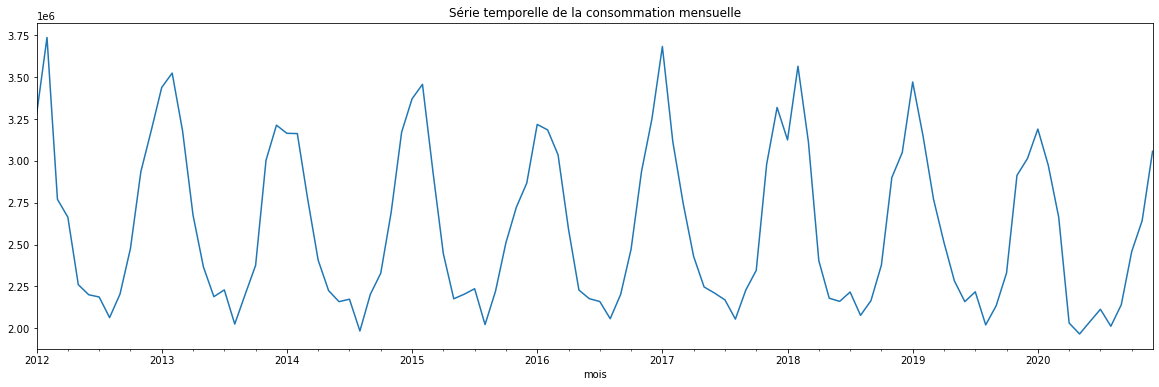

In [13]:
conso['consommation'].plot(figsize=(20, 6))
plt.title('Série temporelle de la consommation mensuelle')
plt.savefig('P9_consommation_mensuelle.jpg')

In [14]:
df_dju=pd.read_excel('calcul_DJU.xlsx', skiprows=11, index_col=0)
df_dju.head()

/home/kipengui/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
2020,339.0,249.6,269.2,105.6,85.9,37.7,16.5,12.6,46.1,158.9,227.7,336.8,1885.6
2019,404.9,268.8,234.3,177.2,126.8,35.7,10.0,11.8,45.3,136.9,282.6,327.3,2061.8
2018,303.4,432.6,314.4,128.9,74.1,20.1,1.6,13.5,53.7,133.4,282.8,325.9,2084.2
2017,467.9,278.4,208.9,187.1,87.8,21.4,13.5,20.8,74.5,109.3,282.6,369.0,2121.2
2016,364.4,321.6,321.1,214.1,100.7,40.8,14.7,13.8,27.3,177.3,285.6,390.8,2271.9


In [15]:
df_dju.rename(columns={'JAN':'01',
                   'FÉV':'02',
                   'MAR':'03',
                   'AVR':'04',
                   'MAI':'05',
                   'JUN':'06',
                   'JUI':'07',
                   'AOÛ':'08',
                   'SEP':'09',
                   'OCT':'10',
                   'NOV':'11',
                   'DÉC':'12'},
          inplace=True)

In [16]:
df_dju.drop(columns='Total', inplace=True)

In [17]:
df_dju=pd.DataFrame(df_dju.unstack()).reset_index()
df_dju

,level_0,level_1,0
0,01,2020,339.0
1,01,2019,404.9
2,01,2018,303.4
3,01,2017,467.9
4,01,2016,364.4
...,...,...,...
103,12,2016,390.8
104,12,2015,248.1
105,12,2014,368.2
106,12,2013,349.5


In [18]:
df_dju['level_1']=df_dju['level_1'].astype(str)

In [19]:
df_dju['mois']= df_dju['level_1'] + '-' + df_dju['level_0']
df_dju['mois']=pd.to_datetime(df_dju['mois'])
df_dju.rename(columns={0:'dju'}, inplace=True)
df_dju=df_dju[['mois', 'dju']]
df_dju.sort_values('mois', ascending=True, inplace=True)
df_dju.set_index('mois', inplace=True)
df_dju.head()

/home/kipengui/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,dju
mois,
2012-01-01,336.0
2012-02-01,435.9
2012-03-01,210.5
2012-04-01,231.2
2012-05-01,93.8


In [20]:
data=pd.merge(conso, df_dju, left_index=True, right_index=True)
data.head()

,consommation,dju
mois,,
2012-01-01,3.276551e+06,336.0
2012-02-01,3.736692e+06,435.9
2012-03-01,2.770680e+06,210.5
2012-04-01,2.663313e+06,231.2
2012-05-01,2.260570e+06,93.8


# Correction des données de consommation mensuelles de l'effet température

Régression linéaire

In [21]:
x=data['dju']
y=data['consommation']

In [22]:
lm=pg.linear_regression(x, y)
lm

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.986665e+06,17725.351368,112.080412,6.133429e-112,0.946468,0.945963,1.951522e+06,2.021807e+06
1,dju,3.446652e+03,79.615956,43.290964,3.286154e-69,0.946468,0.945963,3.288805e+03,3.604498e+03


In [23]:
lm.loc[1, 'coef']

3446.651510509986

Traitement des résidus

In [24]:
# on teste ici la normalité des résidus
# la méthode jarque_bera est utilisé sur des grands échantillons (> 50)

In [25]:
pg.normality(lm.residuals_, method='jarque_bera')

,W,pval,normal
0,0.74401,0.689351,True


(array([ 2.,  1.,  4., 11., 21., 24., 19., 14.,  4.,  8.]),
 array([-319177.75478978, -262496.78061871, -205815.80644764,
        -149134.83227656,  -92453.85810549,  -35772.88393442,
          20908.09023666,   77589.06440773,  134270.0385788 ,
         190951.01274988,  247631.98692095]),
 <BarContainer object of 10 artists>)

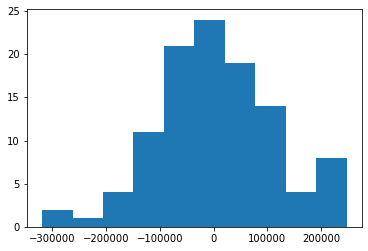

In [26]:
plt.hist(lm.residuals_)

In [27]:
data['conso_corrigée']=data['consommation'] - data['dju'] * lm.loc[1, 'coef']

In [28]:
data

,consommation,dju,conso_corrigée
mois,,,
2012-01-01,3.276551e+06,336.0,2.118476e+06
2012-02-01,3.736692e+06,435.9,2.234297e+06
2012-03-01,2.770680e+06,210.5,2.045160e+06
2012-04-01,2.663313e+06,231.2,1.866447e+06
2012-05-01,2.260570e+06,93.8,1.937274e+06
...,...,...,...
2020-08-01,2.012199e+06,12.6,1.968772e+06
2020-09-01,2.140766e+06,46.1,1.981875e+06
2020-10-01,2.458248e+06,158.9,1.910575e+06


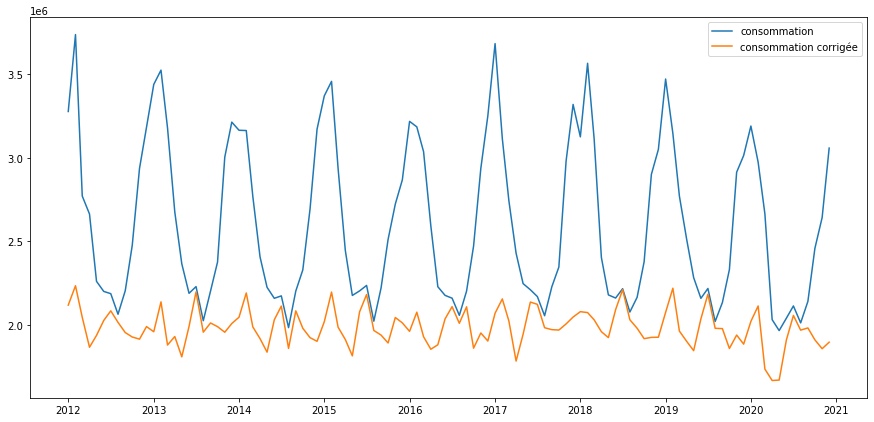

In [29]:
labels=['consommation', 'consommation corrigée']

plt.figure(figsize=(15,7))
plt.plot(data['consommation'])
plt.plot(data['conso_corrigée'])
plt.legend(labels)
plt.savefig('P9_conso_corrigée.jpg')

# Décomposition de la série en tendance et saisonnalité

In [30]:
data_crg=data[['dju', 'conso_corrigée']]

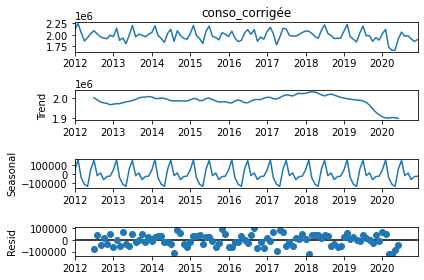

In [31]:
x=data_crg['conso_corrigée']
res=seasonal_decompose(x, model='additif')
res.plot();

# Prévision de la consommation corrigée de l'effet température
### Méthode Holt Winters (lissage exponentielle)

Entrainement jusqu'à 2019, prévision de l'année 2020

/home/kipengui/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


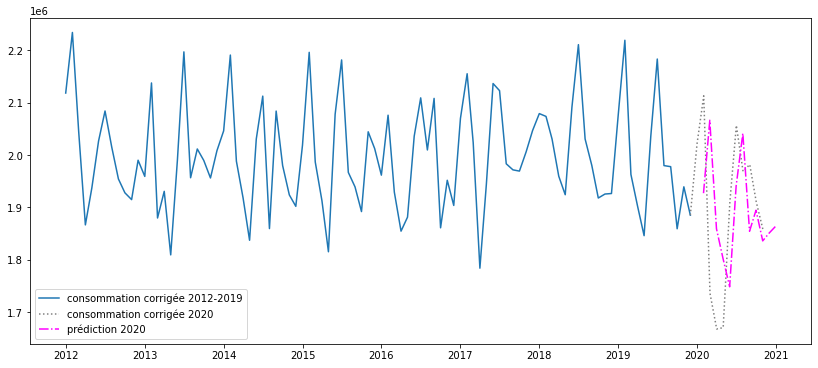

In [32]:
hw = ExponentialSmoothing(np.asarray(x), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(x[:-12], label='consommation corrigée 2012-2019')
plt.plot(x.iloc[95:107], label='consommation corrigée 2020', ls=':', color='grey')
plt.plot(pd.date_range(data_crg.index[len(data_crg)-12], periods=12, freq='M'), hw_pred, 
         label='prédiction 2020', ls='-.', color='magenta')
plt.legend()
plt.savefig('P9_prévision_holt_winters_2.jpg')
plt.show()

MAPE prédiction 2020

In [33]:
sklearn.metrics.mean_absolute_percentage_error(x[-12:], hw_pred)

0.03774307771596379

Entrainement jusqu'à 2020, prévision de l'année 2021

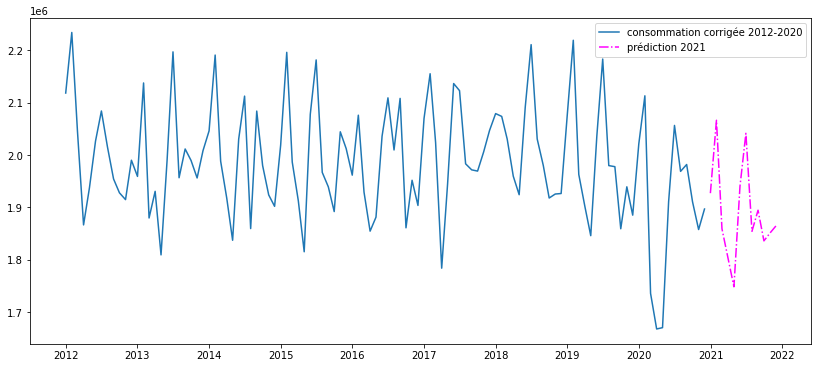

In [34]:
plt.figure(figsize=(14,6))
plt.plot(x, label='consommation corrigée 2012-2020')
plt.plot(pd.date_range(data_crg.index[len(data_crg)-1], periods=12, freq='M'), hw_pred, 
         label='prédiction 2021', ls='-.', color='magenta')
plt.legend()
plt.savefig('P9_prévision_holt_winters_3.jpg')
plt.show()

### Méthode SARIMA

fonction de représentation de la sortie ACF

In [35]:
def plot_sortie_acf( y_acf, x_len, pacf=False):
    if pacf:
        y_acf = y_acf[1:]
    plt.figure(figsize=(14,6))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(x_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(x_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()
    return

Fonction d’Auto-Corrélation (ACF)

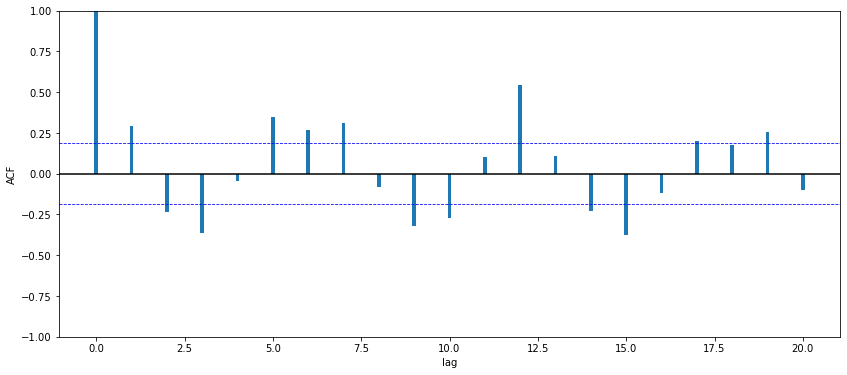

<Figure size 432x288 with 0 Axes>

In [36]:
x_len = len(x) # variable nécessaire pour l'utilisation de plot_sortie_acf

plot_sortie_acf(acf(np.asarray(x)), x_len)
plt.savefig('P9_acf.jpg')

Fonction d’Auto-Corrélation Partielle (PACF)

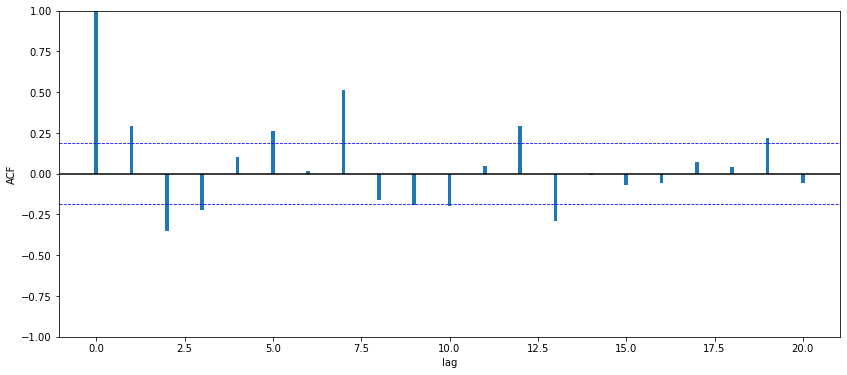

<Figure size 432x288 with 0 Axes>

In [37]:
plot_sortie_acf(pacf(np.asarray(x)), x_len)
plt.savefig('P9_pacf.jpg')

Test de stationnarité

In [38]:
# H0 : La série temporelle n'est pas stationnaire 

In [39]:
resultat = adfuller(x)
print('Test de Dicker-Fuller: %.2f' % resultat[0])
print('p-value: %.2f' % resultat[1])
print('Valeurs critiques:')
for key, value in resultat[4].items():
    print('\t%s: %.3f' % (key, value))

Test de Dicker-Fuller: -1.81
p-value: 0.38
Valeurs critiques:
	1%: -3.501
	5%: -2.892
	10%: -2.583


In [40]:
# la p-value étant supérieur à 0.05, nous ne rejetons donc pas l'hyptothèse nulle

test de stationnarité sur une série différenciée

In [41]:
period=1

resultat = adfuller(x.diff(periods=period)[period:])
print('Test de Dicker-Fuller: %.2f' % resultat[0])
print('p-value: %.2f' % resultat[1])
print('Valeurs critiques:')
for key, value in resultat[4].items():
    print('\t%s: %.3f' % (key, value))

Test de Dicker-Fuller: -4.93
p-value: 0.00
Valeurs critiques:
	1%: -3.500
	5%: -2.892
	10%: -2.583


In [42]:
#from statsmodels.tsa.arima.model import ARIMA
#import statsmodels.tsa.arima.model

Test de Ljung-Box

In [43]:
# test de la blancheur des résiuds

In [44]:
sm.stats.acorr_ljungbox(x[-12:],lags=1, return_df=True)

,lb_stat,lb_pvalue
1,2.754431,0.096985


Entrainement jusqu'à 2019, prédiction de l'année 2020

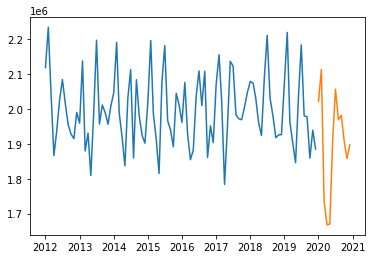

In [45]:
train, test= x[:-12], x.iloc[96:108]
plt.plot(train)
plt.plot(test)
plt.savefig('P9_train_test_2020.jpg')

In [46]:
arima_model=pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2139.472, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2141.349, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2141.874, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2141.634, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2140.245, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=2137.479, Time=0.06 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=2139.473, Time=0.14 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2141.344, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2141.456, Time=0.05 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=2138.287, Time=0.07 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=2138.853, Time=0.09 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=2138.685, Time=0.03 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=2138.458, Time=0.02 sec
 ARIMA(2,0,2)(0,1,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood               -1064.731
Date:                             Mon, 09 Jan 2023   AIC                           2135.461
Time:                                     13:04:07   BIC                           2142.753
Sample:                                 01-01-2012   HQIC                          2138.393
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6144      0.310      1.979      0.048       0.006       1.223
ma.L1         -0.6462      0.256     -2.528      0.011      -1.147      -0.145
sigma2      5.983e+09   2.46e-11   2.43e+20      0.000    5.98e+09    5.98e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                 3.27
Prob(Q):                              0.34   Prob(JB):                         0.19
Heteroskedasticity (H):               1.45   Skew:                             0.22
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+36. Standard errors may be unstable.
"""

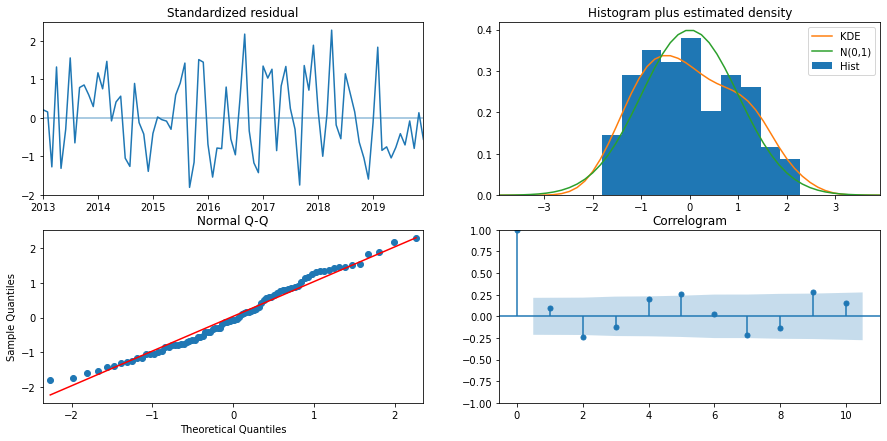

In [47]:
arima_model.plot_diagnostics(figsize=(15,7))
plt.savefig('P9_tracés_résidus_3.jpg')
plt.show()

In [48]:
prediction=pd.DataFrame(arima_model.predict(n_periods=12), index=test.index)
prediction.columns=['estimation_conso']
prediction

,estimation_conso
mois,
2020-01-01,2.077778e+06
2020-02-01,2.220946e+06
2020-03-01,1.963868e+06
2020-04-01,1.902440e+06
2020-05-01,1.846205e+06
2020-06-01,2.036247e+06
2020-07-01,2.183640e+06
2020-08-01,1.979883e+06
2020-09-01,1.977802e+06


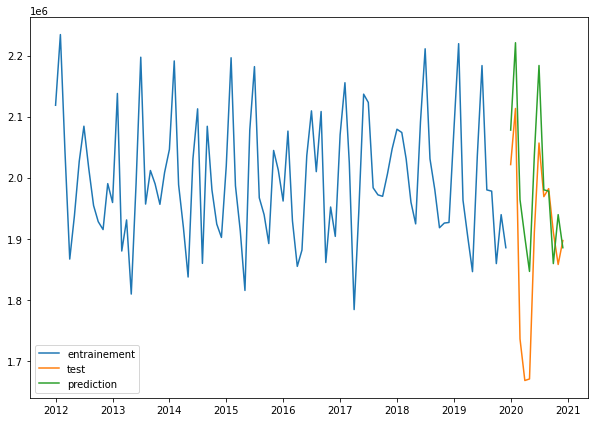

In [49]:
plt.figure(figsize=(10,7))
plt.plot(train, label='entrainement')
plt.plot(test, label='test')
plt.plot(prediction, label='prediction')
plt.savefig('P9_train_test_pred_2020.jpg')
plt.legend()

In [50]:
sklearn.metrics.mean_absolute_percentage_error(x[-12:], prediction['estimation_conso'])

0.05577226907134988